In [2]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# By using trange instead of range, we get a nice progress bar
from tqdm import trange

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

In [3]:
#used the thomas algorithm, taken from another course


# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

## Implementation of 1st and 2nd order version of heat eqn
Chose Crank-Nicolson as 2nd order method, and Euler as 1st order method. Crank-Nicolson was chosen (as opposed to Euler method) due to it having a faster convergence speed.

In [4]:
def u0(x):
    
    u = 2*np.pi*x - np.sin(2*np.pi*x)
    u[0]=0
    u[-1]=0
    """u=np.zeros_like(x)
    indices = np.where(x<0.5)
    i_end=indices[0][-1]
    u[:i_end+1] = 2 * x[:i_end+1]
    u[i_end+1:] = 2*(1 - x[i_end+1:])"""
    return u



def diffusion(theta,u0,h,k,tmax,t0=0,g0=0,g1=0,xmax=1,xmin=0,):
    Nx = int((xmax-xmin)/h)+1
    
    X = np.linspace(xmin,xmax,Nx)

    Nt = int((tmax-t0)/k) + 1
    

    #creating a matrix for taking in the different values
    T = np.zeros((Nt+1,Nx))

    r = k/(h**2)

    sub = np.zeros(Nx-3)
    main = np.zeros(Nx-2)

    sub.fill(r)
    main.fill(r)

    R  = diags(diagonals = [sub*(1-theta), 1 - main*2*(1-theta), sub*(1-theta)], offsets = [1, 0, -1])
    L  = diags(diagonals = [-sub*theta, 1 + main*2*theta, -sub*theta], offsets = [1, 0, -1])

    #initialising T

    T[0] = u0(X)

    for t in trange (Nt):
        rhs = R.dot(T[t,1:-1]) 
        T[t+1,1:-1] = tdma(L,rhs)
        T[t+1,0] = r*theta*g0
        T[t+1,-1] = r*theta*g1
    return T, X

In [30]:
xmax = 1
xmin = 0

h = 0.1

tmax = 0.045*16
#this equates to 24 hrs
t0=0

#wished to increase step size of h. must increase k accordingly
k = 0.0045

theta_Euler = 0

T_Euler, X_Euler = diffusion(theta_Euler,u0,h,k,tmax)

theta_CN = 0.5

T_CN, X_CN = diffusion(theta_CN,u0,h,k,tmax)

100%|██████████| 161/161 [00:00<00:00, 40019.14it/s]


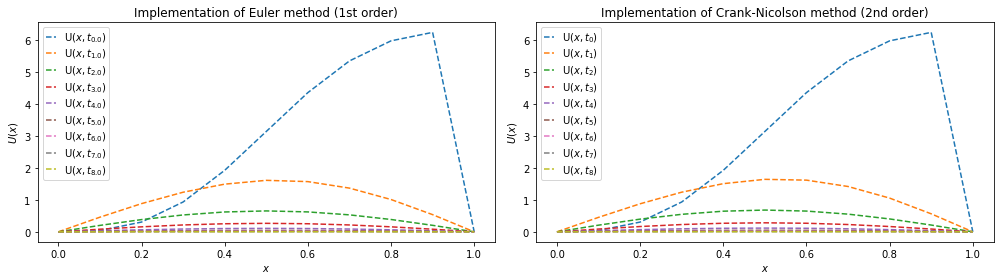

In [31]:
t_len=np.shape(T_CN)[0]



plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
for i in range(0,t_len,20):
    plt.plot(X_Euler,T_Euler[i],"--",label='U$(x,t_{'+str(i/20)+'})$')
plt.ylabel("$U(x)$")
plt.xlabel("$x$")
plt.tight_layout()
plt.legend(loc=2,prop={'size':10},borderpad = 0.3,labelspacing = 0.3,handlelength = 1)
plt.title("Implementation of Euler method (1st order)")
#plt.show()

plt.subplot(1,2,2)
for i in range(0,t_len,20):
    plt.plot(X_CN,T_CN[i],"--",label='U$(x,t_{'+str(int(i/20))+'})$')
plt.ylabel("$U(x)$")
plt.xlabel("$x$")
plt.tight_layout()
plt.legend(loc=2,prop={'size':10},borderpad = 0.3,labelspacing = 0.3,handlelength = 1)
plt.title("Implementation of Crank-Nicolson method (2nd order)")



plt.savefig('2a_sol.png')
plt.show()

In [22]:
xmax = 1
xmin = 0

h = 1/1024

tmax = 0.045 #this equates to 24 hrs
t0=0

#wished to increase step size of h. must increase k accordingly
k = 0.00000045

theta_CN = 0.5

T_CN_analyt, X_CN_analyt = diffusion(theta_CN,u0,h,k,tmax)



100%|██████████| 100001/100001 [00:06<00:00, 16519.53it/s]


In [23]:
print(np.shape(X_CN_analyt))

(1025,)


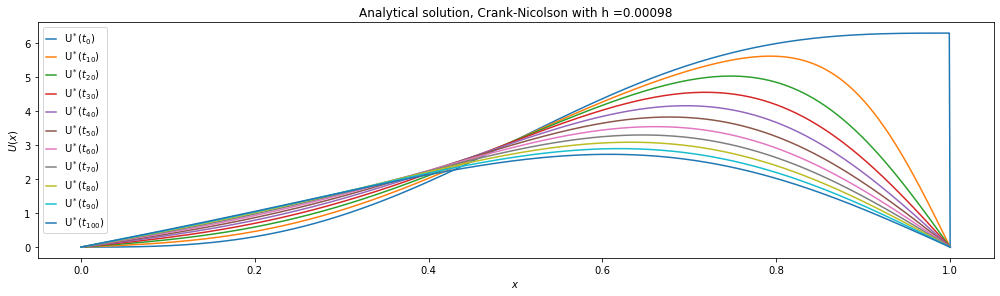

In [27]:
t_len= np.shape(T_CN_analyt)[0]

plt.figure(figsize=(14,4))


for i in range(0,t_len,10000):
    plt.plot(X_CN_analyt,T_CN_analyt[i],label='U$^*(t_{'+str(int(i/1000))+'})$')
plt.ylabel("$U(x)$")
plt.xlabel("$x$")
plt.tight_layout()
plt.title("Analytical solution, Crank-Nicolson with h ="+str(round(h,5)))
plt.legend(loc=2,prop={'size':10},borderpad = 0.3,labelspacing = 0.3,handlelength = 1)
plt.savefig('cn_refsol.png',bbox_inches = "tight")
plt.show()


In [8]:
#making Euler and Crank-Nicolson with the same time length as the analytical solution
#this is to be able to compare

h = 0.1

tmax = 0.045 #this equates to 24 hrs
t0=0

#wished to increase step size of h. must increase k accordingly
k = 0.00000045

theta_Euler = 0

T_Euler, X_Euler = diffusion(theta_Euler,u0,h,k,tmax)

theta_CN = 0.5

T_CN, X_CN = diffusion(theta_CN,u0,h,k,tmax)

100%|██████████| 100001/100001 [00:02<00:00, 40683.54it/s]


In [9]:
#so the time we will use for them all will be -1
def error(U_analyt,U_numeric,X_analyt,X_numeric):
    
    err = 0
    
    M = len(X_numeric) + 2
    
    #finding difference in indices
    i=1
    
    print(X_analyt)
    print(X_numeric[1])
    
    indx = np.where(X_analyt == X_numeric[i])[0][0]
    while indx==0:
        i+=1
        indx = np.where(X_analyt == X_numeric[i])[0][0]
    
    upper = np.sum((1/M)*(U_analyt[-1,::indx] - U_numeric[-1,:])**2)
    lower = np.sum((1/M)*(U_analyt[-1,::indx])**2)
    
    err = np.sqrt(upper/lower)
        
    return err

#Starting with Euler vs analytic

#these must be constant, while h varies
tmax = 0.045 
t0=0
k = 0.00000045
theta_Euler = 0



max_it = int(np.log2(np.shape(T_CN_analyt)[1]))


err_vec = np.zeros(max_it-2)

for i in range(2,max_it):
    
    h = 1/(2**i)
    
    T_Euler, X_Euler = diffusion(theta_Euler,u0,h,k,tmax)
    
    err_vec[i-2] = error(T_CN_analyt, T_Euler, X_CN_analyt, X_Euler)




  3%|▎         | 2928/100001 [00:00<00:03, 29032.64it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.25


  4%|▍         | 4263/100001 [00:00<00:02, 37949.33it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.125


  4%|▎         | 3577/100001 [00:00<00:02, 35499.62it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.0625


  3%|▎         | 3400/100001 [00:00<00:03, 29672.25it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.03125


  4%|▍         | 4081/100001 [00:00<00:02, 35869.49it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.015625


  3%|▎         | 2978/100001 [00:00<00:03, 26072.02it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.0078125


  3%|▎         | 2709/100001 [00:00<00:04, 23981.67it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.00390625


100%|██████████| 100001/100001 [00:03<00:00, 25475.96it/s]


[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.001953125


[2. 3. 4. 5. 6. 7. 8. 9.]
[5.04069804e-02 1.34210847e-02 3.36979190e-03 8.40941812e-04
 2.08030031e-04 4.98055486e-05 1.04688568e-05 2.48203908e-06]


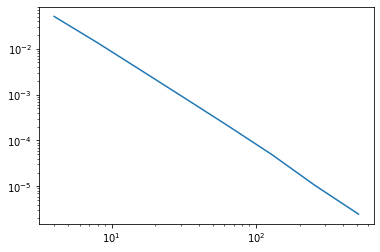

In [10]:
m = np.linspace(2,max_it-1,max_it-2)
plt.loglog(2**m,err_vec)

print(m)
print(err_vec)

In [11]:
import csv

file = open('MyData', 'w')

x = 2**m

y = err_vec

z = np.array([x,y])

for i in zip(*z):
    file.write("{0}\t{1}\n".format(*i))

file.close()

In [12]:
#so the time we will use for them all will be -1
def error(U_analyt,U_numeric,X_analyt,X_numeric):
    
    err = 0
    
    M = len(X_numeric) + 2
    
    #finding difference in indices
    i=1
    
    print(X_analyt)
    print(X_numeric[1])
    
    indx = np.where(X_analyt == X_numeric[i])[0][0]
    while indx==0:
        i+=1
        indx = np.where(X_analyt == X_numeric[i])[0][0]
    
    upper = np.sum((1/M)*(U_analyt[-1,::indx] - U_numeric[-1,:])**2)
    lower = np.sum((1/M)*(U_analyt[-1,::indx])**2)
    
    err = np.sqrt(upper/lower)
        
    return err

#Crank-Nicolson vs analytic

#these must be constant, while h varies
tmax = 0.045 
t0=0
k = 0.00000045
theta_CN = 0.5



max_it = int(np.log2(np.shape(T_CN_analyt)[1]))


err_vec_CN = np.zeros(max_it-2)

for i in range(2,max_it):
    
    h = 1/(2**i)
    
    T_CN, X_CN = diffusion(theta_CN,u0,h,k,tmax)
    
    err_vec_CN[i-2] = error(T_CN_analyt, T_CN, X_CN_analyt, X_CN)


  4%|▍         | 3977/100001 [00:00<00:02, 39561.30it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.25


  4%|▍         | 4139/100001 [00:00<00:02, 37434.20it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.125


  4%|▎         | 3590/100001 [00:00<00:03, 31118.29it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.0625


  4%|▍         | 3833/100001 [00:00<00:02, 38096.24it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.03125


  3%|▎         | 2940/100001 [00:00<00:03, 29265.71it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.015625


  3%|▎         | 2842/100001 [00:00<00:03, 28153.81it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.0078125


  3%|▎         | 2677/100001 [00:00<00:03, 26576.26it/s]

[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.00390625


100%|██████████| 100001/100001 [00:04<00:00, 23704.64it/s]


[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 9.98046875e-01
 9.99023438e-01 1.00000000e+00]
0.001953125


In [13]:
file = open('MyData_CN', 'w')

x = 2**m

y = err_vec_CN

z = np.array([x,y])

for i in zip(*z):
    file.write("{0}\t{1}\n".format(*i))

file.close()

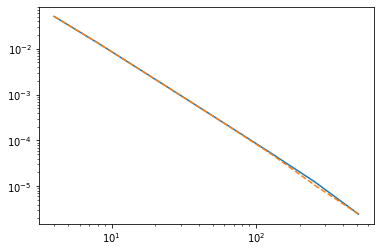

In [16]:
plt.loglog(x,err_vec_CN)
plt.loglog(x,err_vec,"--")